# 3. Sobel and Canny Edge Detection

## Table of Contents
1. [Libraries](#libraries)
2. [Sobel Edge Detection](#sobel)
3. [Canny Edge Detection](#canny)

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [3]:
import cv2
import skimage
import numpy as np
from scipy import ndimage
import skimage.color as sc
from skimage import exposure
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_filter as gauss
from scipy.ndimage import median_filter as med

## Sobel Edge Detection <a class="anchor" id="sobel" ></a>

As a first step in extracting features, you will apply the Sobel edge detection algorithm. This finds regions of the image with large gradient values in multiple directions. Regions with high omnidirectional gradient are likely to be edges or transitions in the pixel values. 

The code in the cell below applies the Sobel algorithm to the median filtered image, using these steps:

1. Convert the color image to grayscale for the gradient calculation since it is two dimensional.
2. Compute the gradient in the x and y (horizontal and vertical) directions. 
3. Compute the magnitude of the gradient.
4. Normalize the gradient values. 

In [4]:
def edge_sobel(image):
    #from scipy import ndimage
    #import skimage.color as sc
    #import numpy as np
    image = sc.rgb2gray(image) # Convert color image to gray scale
    dx = ndimage.sobel(image, 1)  # horizontal derivative
    dy = ndimage.sobel(image, 0)  # vertical derivative
    mag = np.hypot(dx, dy)  # magnitude
    mag *= 255.0 / np.amax(mag)  # normalize (Q&D)
    mag = mag.astype(np.uint8)
    return mag

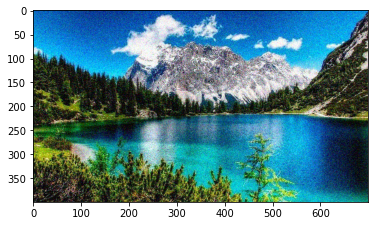

In [11]:
original_image = np.load('../data/img.npy')

img = skimage.util.random_noise(original_image)
plt.imshow(img)

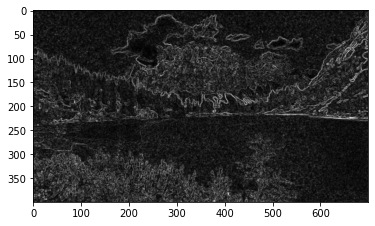

In [12]:
img_med = med(img, size=2)
img_edge = edge_sobel(img_med)
plt.imshow(img_edge, cmap="gray")

Now let's try with the more blurred gaussian filtered image.

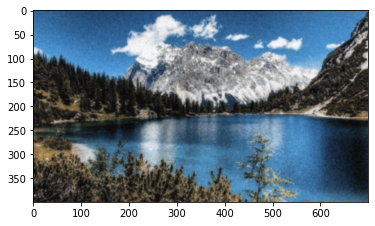

In [13]:
img_gauss = gauss(img, sigma=1)   
plt.imshow(img_gauss)

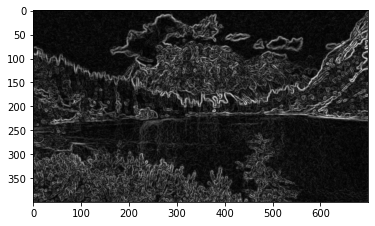

In [14]:
img_edge = edge_sobel(img_gauss)
plt.imshow(img_edge, cmap="gray")

## Canny Edge Detection <a class="anchor" id="canny" ></a>

Steps:
1. Noise Reduction
2. Gradient Calculation
3. Non-maximum Supression
4. Double Threshold
5. Edge Tracking by Hysteresis

**Pre-requisite:** Convert the image to grayscale before algorithm.

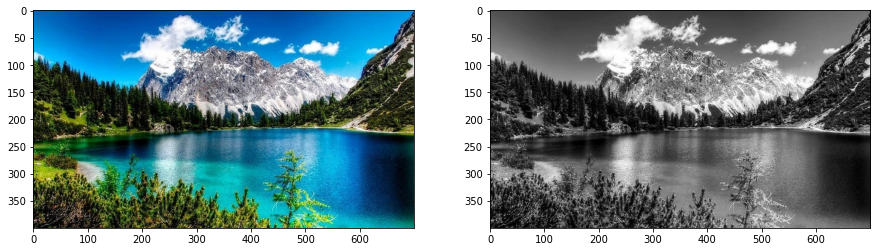

In [15]:
img = cv2.imread('../data/image.jpg')

img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_color)
plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap="gray")

### 1. Noise Reduction
Edge detection are highly sensitive to image noise due to the derivatives behind the algorithm.

We can apply a Gaussian Kernel, the size of the kernel depends on the expected blurring effect. The smaller the less blurring effect.

Equation for Gaussian Kernel of size $(2k+1) \times (2k+1)$

$$
H_{i, j} = \frac{1}{2\pi\sigma^2}exp(-\frac{(i-(k+1))^2 + (j-(k+1))^2}{2\sigma^2}); 1\leq i, j \leq (2k+1)
$$

In [16]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

### 1.1 Sigma Parameter $\sigma$

In [17]:
# Change this parameter
sigma = 10 # 1, 3, 5, 10, 20, ...

### 1.2 Kernel Size Parameter

In [18]:
kernel_size = 3

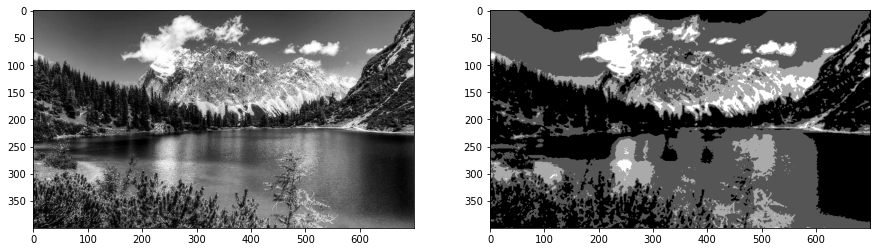

In [19]:
img_gaussian = convolve(img_gray, gaussian_kernel(kernel_size, sigma))

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_gaussian, cmap="gray")

### 2. Gradient Calculation

Edges correspond to a change of pixels intensity. 

To detect it, the easiest way is to apply filters that highlight this intensity change in both directions: 
- horizontal $(x)$ 
- and vertical $(y)$

It can be implemented by convoling $I$ with *Sobel kernels* $Kx$ and $Ky$

$$
K_x = \begin{bmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1
\end{bmatrix}, K_y = \begin{bmatrix}
1 & 2& 1\\
0 & 0 & 0\\
-1 & -2 & -1
\end{bmatrix}
$$

Then, the magnitude $G$ and the slope $\theta$ of the gradient are calculated as follow:

$$
|G| = \sqrt{I_x^2 + I_y^2},
\theta(x, y) = arctan(\frac{I_y}{I_x})
$$

In [20]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

/var/folders/kx/y44q1zf12s573t4djdfy9_n00000gn/T/ipykernel_9902/65442114.py:5: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Ix = ndimage.filters.convolve(img, Kx)
/var/folders/kx/y44q1zf12s573t4djdfy9_n00000gn/T/ipykernel_9902/65442114.py:6: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Iy = ndimage.filters.convolve(img, Ky)


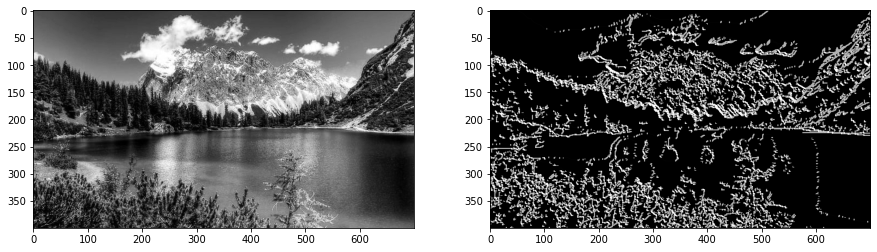

In [21]:
G, theta = sobel_filters(img_gaussian)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(G, cmap="gray")

### 3. Non-Maximum supression

1. Create a matrix initialized to 0 of the same size of the original gradient intensity matrix
2. Identify the edge direction based on the angle value from the angle matrix
3. Check if the pixel in the same direction has a higher intensity than the pixel that is currently processed
4. Return the image processed with the non-max suppression algorithm.

In [22]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

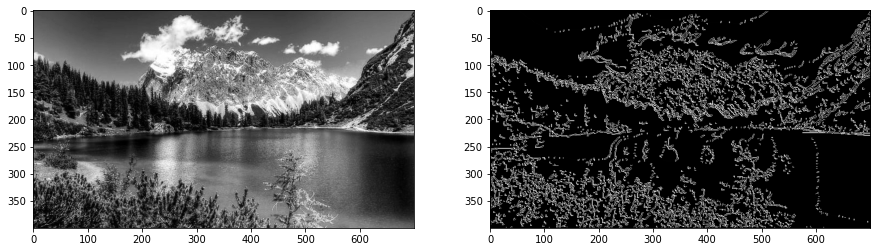

In [23]:
img_nonmax = non_max_suppression(G, theta)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_nonmax, cmap="gray")

### 4. Double threshold

- Strong pixels are pixels that have an intensity so high that we are sure they contribute to the final edge.
- Weak pixels are pixels that have an intensity value that is not enough to be considered as strong ones, but yet not small enough to be considered as non-relevant for the edge detection.
- Other pixels are considered as non-relevant for the edge.

In [29]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res)

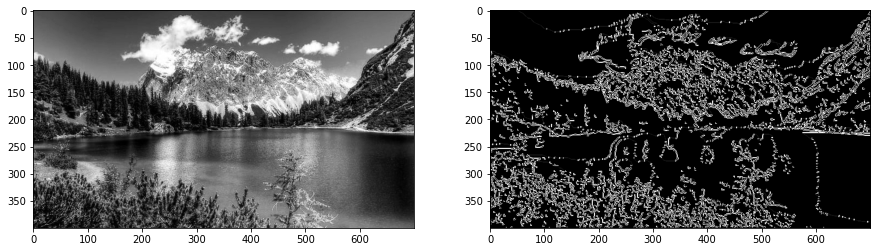

In [30]:
img_threshold = threshold(img_nonmax)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_threshold, cmap="gray")

### 5. Edge Tracking by Hysteresis

The hysteresis consists of transforming weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one

In [31]:
def hysteresis(img, weak = 75, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

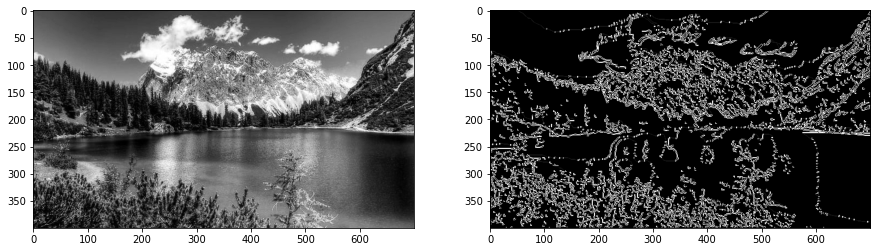

In [32]:
img_final = hysteresis(img_threshold)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_final, cmap="gray")

In [18]:
# TODO: Challenge